# <center> Neural Networks and Deep Learning (CSCI 5922)</center>
# <center> Spring 2020 </center>

**Name:** Nicholas Renninger

## Goal

The goal of this assignment is to introduce neural networks in terms of ideas you are already familiar with:  linear regression and classification

## Dataset

You are given a dataset with 2 input variables ($x_1$, $x_2$) and an output variable ($y$).

In [102]:
from matplotlib import pyplot as plt
import numpy as np
import os
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

# Load data
data = np.loadtxt(os.path.join('data', 'assign1_data.txt'),  delimiter=',')
predictors = data[:, :2]
targets = data[:, 2]
target_class_labels = data[:, 3]

numExamples = len(predictors)

## Part 1

Write a program to find the exact least squares solution to $y = w_1 x_1 + w_2 x_2 + b$ for the above dataset, using the normal equation.

Complete the following function below and use it to answer questions (A) and (B). 

**Note:** Please do not change the interface of the given function.

In [103]:
def least_squares(X, y):
    """
    Finds the Least Squares solution
    
    Parameters
    ----------
    X : NumPy array of features (size : no of examples X features)
    y : Numpy array of output value 'y' (size : no of examples X 1)
    
    Returns
    -------
    w : solution array
    """
    
    # as is done in MATLAB, since we are really solving:
    #      (X_b^T * X_b) * w = X_b^T * y
    # for the computation of the moore-penrose inverse, we can help speed up 
    # stabilize calculation by directly solving the matrix equation instead 
    # relying on expensive inverse calculations
    X_b = getFeaturesWithBias(X)
    w = np.linalg.solve(X_b.T @ X_b, X_b.T) @ y
    
    return w

def getFeaturesWithBias(X):
    """
    Returns the Feature Matrix with a column of ones added for the bias term
    
    need to add a column of ones to the feature matrix to account for the
    bias term 'b' in our linear model:
            y = w_1 * x_1 + w_2 * x_2 + b
    
    Parameters
    ----------
    X : NumPy array of features (size : no of examples X features)
    
    Returns
    -------
    X_b : NumPy array of features with bias column added 
          (size : no of examples X (features + 1))
          
    Examples
    --------
    X = [[0.3 0.5]
         [0.5 0.4]
         [0.7 1.5]]
         
         
    X_b = [[0.3 0.5 1.0]
           [0.5 0.4 1.0]
           [0.7 1.5 1.0]]
    """
    
    numFeatures, _ = np.shape(X)
    biasFeatureMat = np.ones(shape=(numFeatures, 1))
    X_b = np.concatenate((X, biasFeatureMat), axis=1)
    
    return X_b

def computeQuadraticLoss(y, y_hat):
    """
    Computes the quadratic loss for each target-target_est pair
    
    Parameters
    ----------
    y : Numpy array of output value 'y' (size : no of examples X 1)
    y_hat : Numpy array of estimated output value (size : no of examples X 1)
    
    Returns
    -------
    loss : Numpy array of losses for each pair of y-y_hat
           (size : no of examples X 1)
    """
    
    loss = np.square(y - y_hat)
    
    return loss


### (A) Report the values of $w_1$, $w_2$, and $b$.

In [110]:
weights = least_squares(predictors, targets)
regressed_targets = getFeaturesWithBias(predictors) @ weights

print('w_1:', weights[0])
print('w_2:', weights[1])
print('b:', weights[2])

w_1: -2.044242595137635
w_2: 3.9968601686593255
b: -0.9242908118675918


Now, we can examine the fitting performance of our linear regression model. Below, we see how the regressed target values compare to the observed target values for each predictor. They match quite well, as is expected on the test set.

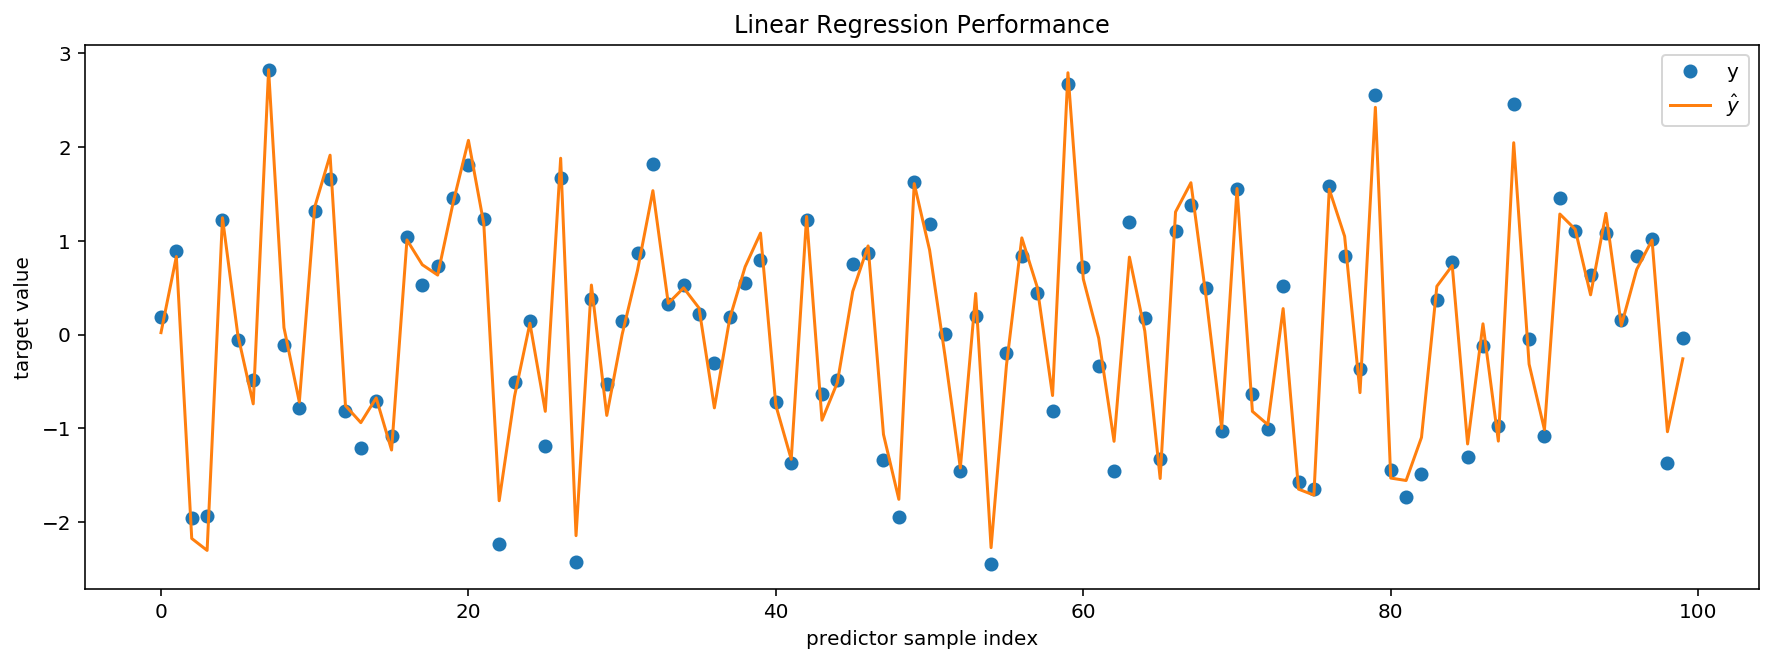

In [105]:
predictor_indices = range(0, numExamples)

# make it wide to see the timeseries more easily
plt.rcParams['figure.figsize'] = [15, 5]
plt.plot(predictor_indices, targets, 'o', label=r'y')
plt.plot(predictor_indices, regressed_targets, '-', label=r'$\hat{y}$')

plt.legend()
plt.title('Linear Regression Performance')
plt.xlabel('predictor sample index');
plt.ylabel('target value');

Here we investigate the loss term as a function of each predictor. It is as expected, with the loss generally being quite low, except for some outliers that don't fit the linear model well.

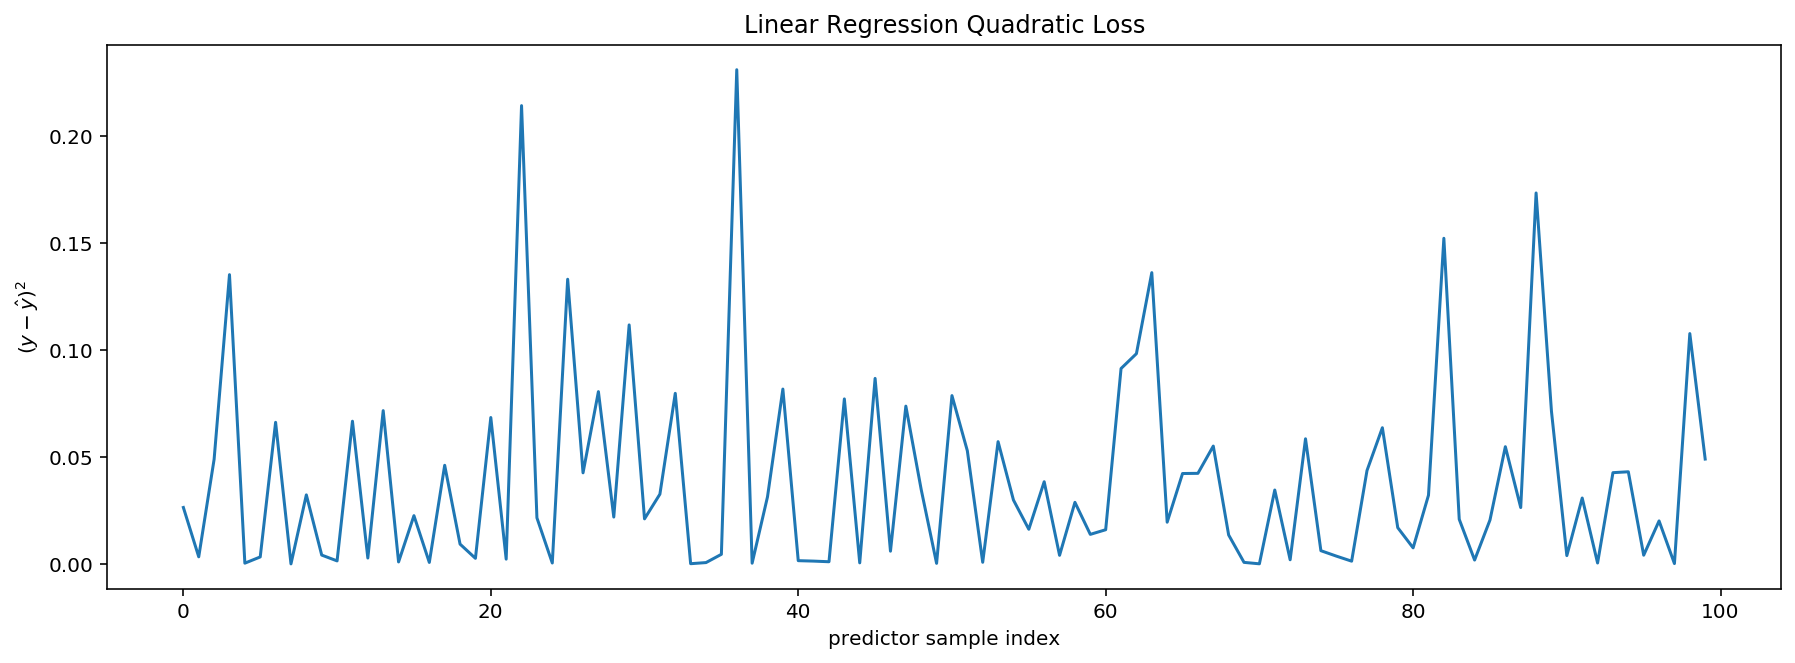

In [106]:
# make it wide to see the timeseries more easily
plt.rcParams['figure.figsize'] = [15, 5]
loss = computeQuadraticLoss(targets, regressed_targets)
plt.plot(predictor_indices, loss, '-')

plt.title('Linear Regression Quadratic Loss')
plt.xlabel('predictor sample index');
plt.ylabel(r'$(y - \hat{y})^2$');

### (B) What function or method did you use to find the least-squares solution?

The least-squares solution is the result of optimizing:

\begin{equation*}
X \cdot \mathbf{w} = Y
\end{equation*}

where $\mathbf{\hat{w}}$ is the estimated weight vector, $Y$ is the target vector, and $\hat{Y}$ is the regressed target vector. We optimize our quadratic loss to find $\mathbf{\hat{w}}$:
\begin{align*}
\mathbf{\hat{w}} &= \mathbf{w} \mid (Y - \hat{Y})^T \cdot (Y - \hat{Y}) = 0 \\
                 &= \mathbf{w} \mid (Y - X \cdot \mathbf{w})^T \cdot (Y - X \cdot \mathbf{w}) = 0 \\
\end{align*}


The solution, assuming a linearly independent columns of $X$, can be robustly computed with the Moore-Penrose psuedoinverse of the predictor matrix $X$:

\begin{equation*}
X^{+}=\left(X^{T} X\right)^{-1} X^T
\end{equation*}

Thus, the loss-minimizing weight vector $\mathbf{\hat{w}}$ is computed as:
\begin{equation*}
\mathbf{\hat{w}} = X^{+} Y
\end{equation*}


## Part 2

Implement linear regression of y on X via first-order optimization of the least-squares objective. Write a program that determines the coefficients {w1,w2,b}. Implement stochastic gradient descent, batch gradient descent, and mini-batch gradient descent. You will need to experiment with updating rules, step sizes (i.e. learning rates), stopping criteria, etc. Experiment to find settings that lead to solutions with the fewest number of sweeps through the data.

Complete the following functions below and use them to answer questions (A), (B) and (C). You may find the shuffle function from scikit-learn useful. 

Use the following hyperparameters:

Learning rates = [0.001, 0.05, 0.01, 0.05, 0.1, 0.3]

MaxIter = [10, 50, 100, 500, 1000, 5000, 10000, 25000, 50000]

**Note:** Please do not change the interface of the given functions.

In [107]:
from sklearn.utils import shuffle

def online_epoch(X, y, w):
    """
    One epoch of stochastic gradient descent (i.e. one sweep of the dataset).
    
    Parameters
    ----------
    X : NumPy array of features (size : no of examples X features)
    y : Numpy array of class labels (size : no of examples X 1)
    w : array of coefficients from the previous iteration
    
    Returns
    -------
    Coefficients of the model (after updating)
    """
    pass

def batch_update(X, y, w):
    """
    One iteration of full-batch gradient descent.
    
    Parameters
    ----------
    X : NumPy array of features (size : no of examples X features)
    y : Numpy array of class labels (size : no of examples X 1)
    w : array of coefficients from the previous iteration
    
    Returns
    -------
    Coefficients of the model (after updating)
    """
    pass

def mini_batch_update(X, y, w, batch_size):
    """
    One epoch of mini-batch SGD over the entire dataset (i.e. one sweep of the dataset).
    
    Parameters
    ----------
    X : NumPy array of features (size : no of examples X features)
    y : Numpy array of class labels (size : no of examples X 1)
    w : array of coefficients from the previous iteration
    batch_size : size of the batch for gradient update
    
    Returns
    -------
    Coefficients of the model (after updating)
    """
    pass

def least_squares_grad_desc(X, y, maxIter, alpha, update, *batch_size):
    """
    Implements least squares with gradient descent.
    
    Parameters
    ----------
    X : NumPy array of features (size : no of examples X features)
    y : Numpy array of class labels (size : no of examples X 1)
    maxIter : Maximum number of iterations allowed
    alpha : Learning rate
    update : update function to utilize (one of online, batch, mini-batch)
    batch_size : number of examples in a batch (only useful when update = mini_batch_update)
    
    Returns
    -------
    Coefficients of the model (after updating)
    
    Note : *batch_size is an optional argument and only to be used when doing mini-batch Gradient Descent 
    """
    pass

(A) Report the values of $w_1$, $w_2$, and $b$. 

(B) What settings worked well for you:  online vs. batch vs. minibatch? What step size? How did you decide to terminate?

(C) Make a graph of error on the entire data set as a function of epoch. An epoch is a complete sweep through all the data (which is one iteration for full-batch gradient descent).

## Part 3

The data set from a regression problem can be converted into a classification problem simply by using the sign of (+ or -) as representing one of two classes. In the data set used in Part 1 and 2, you'll see the variable z that represents this binary (0 or 1) class.

Use the perceptron learning rule to solve for the coefficients {$w_1$, $w_2$, $b$} of this classification problem.   

Two warnings: First, your solution to Part 3 should require only a few lines of code changed from the code you wrote for Part 2. Second, the Perceptron algorithm will not converge if there is no exact solution to the training data. It will jitter among coefficients that all yield roughly equally good solutions.

Complete the following functions below and use them to answer questions (A) and (B). 

**Note:** Please do not change the interface of the given functions.

In [108]:
def perceptron_update(X, y, w):
    """
    One epoch of Perceptron updates (full sweep of the dataset).
    
    Parameters
    ----------
    X : NumPy array of features (size : no of examples X features)
    y : Numpy array of class labels (size : no of examples X 1)
    w : array of coefficients from the previous iteration
    
    Returns
    -------
    w : Coefficients of the classifier (after updating)
    incorrect : Incorrectly classified examples
    """
    pass

def perceptron(X, y, maxIter, alpha):
    """
    Implements the Perceptron algorithm.
    
    Parameters
    ----------
    X : NumPy array of features (size : no of examples X features)
    y : Numpy array of class labels (size : no of examples X 1)
    maxIter : The maximum number of iterations allowed 
    alpha : Learning Rate
    
    Returns
    -------
    w : Coefficients of the classifier
    incorrect : Incorrectly classified examples on termination
    """
    pass

(A) Report the values of coefficients $w_1$, $w_2$, and $b$.

(B) Make a graph of the accuracy (% correct classification) on the training set as a function of epoch.

## Part 4

In machine learning, we really want to train a model based on some data and then expect the model to do well on "out of sample" data. Try this with the code you wrote for Part 3:  Train the model on the first {5, 10, 25, 50, 75} examples in the data set and test the model on the final 25 examples.

Complete the following function below and use it to answer (A). 

**Note:** Please do not change the interface of the given function.

In [109]:
def classify(X, y, w):
    """
    Use this function to classify examples in the test set
    
    Parameters
    ----------
    X : Test set features
    y : Test set labels
    w : Perceptron coefficients
    
    Returns
    -------
    correct : number of correctly classified examples
    """
    pass

How does performance on the test set vary with the amount of training data? Make a bar graph showing performance for each of the different training set sizes.